<center>
    <img src="https://weclouddata.s3.amazonaws.com/images/logos/wcd_logo_new_2.png" width='30%'> 
</center>

----------

<h1 align="center"> Midterm </h1>
<br>
<center align="left"> <font size='4'>  Developed by: </font><font size='4' color='#33AAFBD'>WeCloudData</font></center>
<br>

----------


# 1. Import sql
- general idea: my target is classify if a client regularly pay the loan or not, so I decide to build my database on client level. 
- In this case, I'd want to know the following information for each client who has a loan: age at loan; gender; has family or not (some accounts have two clients, so I assume them as joint account for families); credit card type; district; ratio between other transaction and the monthly payment; and the account balance. 
- account balance is a bit tricky as it's a dynamic parameter, I selected the last account balance before loan granted date is the parameter
- for transaction, I calculated the sum of each credit and withdraw k_symbol transaction monthly, and then divided by monthly loan payment to get the ratio. I suppose that the transaction maybe influenced by with/without loans, so I divided them into before loan and during loan.
- last step is to use the above features to train ML

In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Compiling login info
DB_USER = 'cathy' # your username in the mysql server
DB_PASS = 'richbird' # your password in the mysql server
DB_HOST = 'localhost' # change to hostname of your server if on cloud
DB_NAME = 'bank' # name of your database
POOL_SIZE =50

In [3]:
connection = pymysql.connect(host=DB_HOST,
                             user=DB_USER,
                             password=DB_PASS,
                             db=DB_NAME,
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

sql="""
select a.client_id,
       a.account_id,
       a.loan_id,
#        t.trans_id,
       case when a.family_size = 2 then 1 else 0 end as is_family,
       a.gender,
       a.age_loan,
       timestampdiff(year, a.date, a.loan_granted_date) as account_year_before_loan,
       a.date as account_date,
       a.loan_granted_date,
       a.loan_end_date,
       a.duration as loan_duration,
       a.monthly_payment,
       t.date as transcation_date,
       t.type as trascation_type,
       t.k_symbol,
       t.operation,
       t.amount as transaction_amount,
       t.balance as account_balance,
       case when datediff(loan_granted_date, t.date)>0 then "BEFORE"
            when datediff(loan_end_date, t.date)<0 then "AFTER"
           else "DURING" end as transaction_before_loan,
       cc.card_type,
       dist.*,
       a.status
from
        (select account.account_id,
                account.date,
               c.client_id,
               c.gender,
               c.family_size,
               timestampdiff(year, c.birth, loan.date) as age_loan,
               c.type,
               account.district_id,
               c.birth,
               loan.date as loan_granted_date,
               date_add(loan.date, interval loan.duration month) as loan_end_date,
               loan.duration,
               loan.payments as monthly_payment,
               loan.amount as total_loan,
               loan.status,
               loan.loan_id
        from account
        left join loan on loan.account_id = account.account_id
        join client_account c on account.account_id = c.account_id
        where loan_id is not null and c.type = 'OWNER'
        order by account.account_id) as a
left join client_credit cc on a.client_id=cc.client_id
left join district dist on dist.district_id = a.district_id
left join trans t on a.account_id = t.account_id
order by client_id
"""

sql2="""
select distinctrow b.client_id,
       avg(b.account_balance) over (partition by client_id) as account_balance
from
    (select a.client_id,
           a.loan_granted_date,
           a.duration as loan_duration,
           a.monthly_payment,
           t.date,
           rank() over (partition by client_id order by t.date desc) as row_num,
           t.balance as account_balance
    from
            (select account.account_id,
                   c.client_id,
                   loan.date as loan_granted_date,
                   date_add(loan.date, interval loan.duration month) as loan_end_date,
                   loan.duration,
                   loan.payments as monthly_payment
            from account
            left join loan on loan.account_id = account.account_id
            join client_account c on account.account_id = c.account_id
            where loan_id is not null and c.type = 'OWNER'
            order by account.account_id) as a
    left join trans t on a.account_id = t.account_id
    where datediff(loan_granted_date, t.date)>0
    order by client_id) as b
where row_num = 1
"""

sql3="""
select
       distinctrow b.client_id,
       max(b.has_neg_balance) over (partition by b.client_id) as has_neg_balance
from
        (select distinctrow a.client_id,
        #     a.loan_granted_date,
        #     a.duration as loan_duration,
        #     a.monthly_payment,
        #     t.date,
        #     t.balance as account_balance,
        #     avg(t.balance) over (partition by a.client_id) as avg_balance,
           case when t.balance>0 then 0 else 1 end as has_neg_balance
        from
            (select account.account_id,
                   c.client_id,
                   loan.date as loan_granted_date,
                   date_add(loan.date, interval loan.duration month) as loan_end_date,
                   loan.duration,
                   loan.payments as monthly_payment
            from account
            left join loan on loan.account_id = account.account_id
            join client_account c on account.account_id = c.account_id
            where loan_id is not null and c.type = 'OWNER'
            order by account.account_id) as a
        left join trans t on a.account_id = t.account_id
        where datediff(loan_granted_date, t.date)>0
        order by client_id) as b
;

"""

df = pd.DataFrame()
balance = pd.DataFrame()
try:
    with connection.cursor() as cursor:
        cursor.execute(sql)
        result = cursor.fetchone()
    
    table = pd.read_sql(sql, con=connection)
    df = pd.DataFrame(table)
    table2 = pd.read_sql(sql2, con=connection)
    balance = pd.DataFrame(table2)
    table3 = pd.read_sql(sql3, con=connection)
    balance2 = pd.DataFrame(table3)

finally:
    connection.close()

# 2. Clean Data
- step1: remove loan transactions, otherwise it will leak data
- step2: remove transactions after finishing the loan, can't use future data to predict
- step3: the people who have no credit cards, fill them as 'none'

In [4]:
# remove information after the loan granted date
loan_clients = df[df["transaction_before_loan"]=='BEFORE']

# fill none to those who haven't credit cards
loan_clients.loc[loan_clients.card_type.isnull(),'card_type'] = 'None'

# change transcation type to credit and withdraw only
loan_clients.loc[:,'trascation_type'] = loan_clients.loc[:,'trascation_type']\
                                  .replace({'VYBER':'WITHDRAW', 'VYDAJ':'WITHDRAW', 'PRIJEM':'CREDIT'})

# fill blanks with other
loan_clients.loc[:,'k_symbol'] = loan_clients.loc[:,'k_symbol'].replace({'':'OTHER', ' ':'OTHER'})

# change dates to datetime
import datetime
loan_clients.loc[:,'account_date'] = pd.to_datetime(loan_clients.loc[:,'account_date'],format='%Y-%m-%d')
loan_clients.loc[:,'loan_granted_date'] = pd.to_datetime(loan_clients.loc[:,'loan_granted_date'],format='%Y-%m-%d')
loan_clients.loc[:,'loan_end_date'] = pd.to_datetime(loan_clients.loc[:,'loan_end_date'],format='%Y-%m-%d')
loan_clients.loc[:,'transcation_date'] = pd.to_datetime(loan_clients.loc[:,'transcation_date'],format='%Y-%m-%d')

# group status A,C to G, B, D to B (good=1, bad=0)
loan_clients.loc[:,'status'] = loan_clients.loc[:,'status'].replace({'A':0, 'C':0, 'B':1, 'D':1})

/home/lancelot/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# 3. Create New Features

In [5]:
# create a dataframe to summarize all the sum of every type of transaction
data = loan_clients[['client_id', 'trascation_type', 'k_symbol', 'transaction_amount']]

cols = [
    'CREDIT_OTHER',
    'CREDIT_UROK',
    'WITHDRAW_OTHER',
    'WITHDRAW_POJISTNE',
    'WITHDRAW_SIPO',
    'WITHDRAW_SLUZBY',
    'WITHDRAW_SANKC. UROK'
]
trans = pd.DataFrame(columns=cols)

sum_amount = pd.DataFrame(data.groupby(['client_id', 'trascation_type', 'k_symbol'])['transaction_amount'].sum())
for k, v in sum_amount.iterrows():
    col_name = "_".join(k[1:])
    value = float(v)
    trans.loc[k[0],col_name] = value 
trans = trans.fillna(0)
trans.head()

,CREDIT_OTHER,CREDIT_UROK,WITHDRAW_OTHER,WITHDRAW_POJISTNE,WITHDRAW_SIPO,WITHDRAW_SLUZBY,WITHDRAW_SANKC. UROK
2,227396.0,1291.0,164427.0,0.0,36330.0,90.0,0.0
25,239345.0,2835.0,98808.0,0.0,127400.0,120.0,0.0
31,1005069.0,4087.0,879593.0,2296.0,95438.0,210.0,0.0
45,445057.0,2303.0,401863.0,1164.0,27804.0,165.0,0.0
46,147290.0,1114.0,82351.0,912.0,27604.0,120.0,0.0


In [6]:
# get total days during the account open date to the morgage granted date
num_day = loan_clients[['client_id', 'loan_granted_date','monthly_payment', 'transcation_date']]\
          .dropna().sort_values(by=['client_id', 'transcation_date'])

num_day = pd.DataFrame(num_day.groupby(['client_id', 'loan_granted_date', 'monthly_payment'])\
          ['transcation_date'].agg('min')).reset_index().set_index('client_id')

num_day['total_day'] = num_day.loan_granted_date.dt.to_period('D')\
                        .astype(int) - num_day.transcation_date.dt.to_period('D').astype(int)


In [7]:
# get the ratio between the monthly sum of each type of transcation over monthly mortgate payment
trans1 = trans.join(num_day)
trans1.iloc[:,:7] = trans1.iloc[:,:7].div(trans1.total_day, axis=0).mul(30, axis=0).round(1)
trans1.iloc[:,:7] = trans1.iloc[:,:7].div(trans1.monthly_payment, axis=0).round(5)
trans1 = trans1.iloc[:,:7]

trans1.head()

,CREDIT_OTHER,CREDIT_UROK,WITHDRAW_OTHER,WITHDRAW_POJISTNE,WITHDRAW_SIPO,WITHDRAW_SLUZBY,WITHDRAW_SANKC. UROK
2,6.46164,0.03667,4.67234,0.00000,1.03235,0.00255,0.0
25,7.33496,0.08688,3.02806,0.00000,3.90428,0.00369,0.0
31,23.99774,0.09758,21.00178,0.05482,2.27876,0.00503,0.0
45,5.96064,0.03084,5.38216,0.01558,0.37238,0.00220,0.0
46,7.54075,0.05704,4.21608,0.04668,1.41322,0.00616,0.0


In [8]:
updated_loan_clients = loan_clients.set_index('client_id').join(trans1)

useless = ['district_id', 'account_id', 'loan_id', 'loan_end_date',
          'transcation_date', 'trascation_type', 'k_symbol', 'operation',
          'transaction_amount','account_balance', 'transaction_before_loan']

updated_loan_clients = updated_loan_clients.drop(columns=useless)

updated_loan_clients = updated_loan_clients.drop_duplicates()

# add feature to show if the account has a record of negative balance
updated_loan_clients = updated_loan_clients.join(balance2.set_index(['client_id']))

updated_loan_clients.shape

(682, 33)

In [9]:
updated_loan_clients = updated_loan_clients.join(balance.set_index('client_id'))

In [10]:
updated_loan_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 2 to 13971
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   is_family                 682 non-null    int64         
 1   gender                    682 non-null    object        
 2   age_loan                  682 non-null    int64         
 3   account_year_before_loan  682 non-null    int64         
 4   account_date              682 non-null    datetime64[ns]
 5   loan_granted_date         682 non-null    datetime64[ns]
 6   loan_duration             682 non-null    int64         
 7   monthly_payment           682 non-null    float64       
 8   card_type                 682 non-null    object        
 9   A2                        682 non-null    object        
 10  A3                        682 non-null    object        
 11  A4                        682 non-null    int64         
 12  A5                  

# 4. Feature Engineering & Visualization

#### 4.1 count number of good loans and bad loans
- imbalance data

''

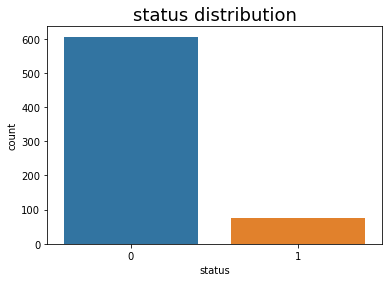

In [11]:
g = sns.countplot(x="status", data=updated_loan_clients)
g.set_ylabel('count')
g.set_title('status distribution', fontsize=18)
;

#### 4.2 family or single
- all family accounts pay loans regularly

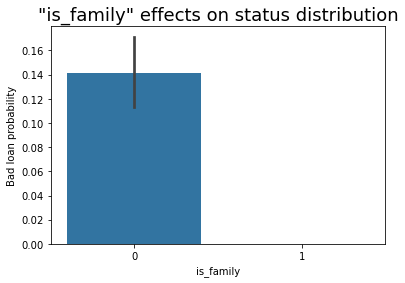

In [12]:
g = sns.barplot(x="is_family", y="status", data=updated_loan_clients)
g.set_ylabel('Bad loan probability')
g.set_title('"is_family" effects on status distribution', fontsize=18);

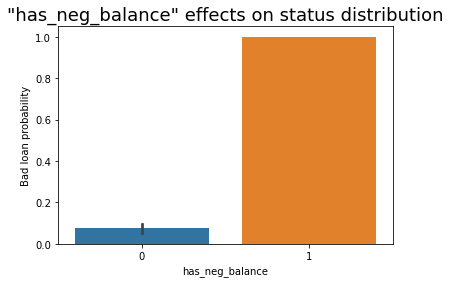

In [13]:
g = sns.barplot(x="has_neg_balance", y="status", data=updated_loan_clients)
g.set_ylabel('Bad loan probability')
g.set_title('"has_neg_balance" effects on status distribution', fontsize=18);

#### 4.3 credit card vs gender
- people without credit card perform worst
- in general, male perform better
- male with gold and junior credit card, and female with classic credit card perform better

/home/lancelot/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/lancelot/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


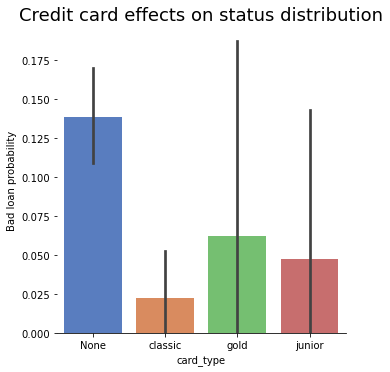

In [14]:
g = sns.factorplot(x="card_type", y="status", data=updated_loan_clients, size=5, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Bad loan probability')
plt.title('Credit card effects on status distribution', fontsize=18);

#### 4.4 age
- middle aged people (30-40) are more likely to pay loans

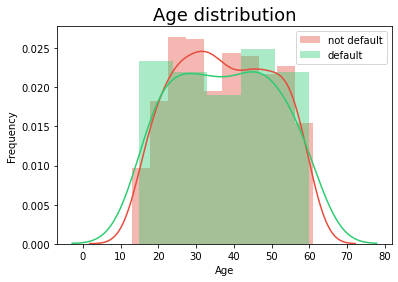

In [15]:
g = sns.distplot(updated_loan_clients["age_loan"][(updated_loan_clients["status"] == 0)], hist=True, color='#e74c3c')
g = sns.distplot(updated_loan_clients["age_loan"][(updated_loan_clients["status"] == 1)], hist=True, color='#2ecc71',ax =g)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["not default","default"])
plt.title('Age distribution', fontsize=18);

#### 4.5 transaction type
- SANKC. UROK (interest for negative balance): before loan, no one has negative value; after loan, some people got negative balance, because this interest is caused by loan, should be deleted because of data leakage
- POJISTNE (insurance payment): values are too small, and not many people have insurance payment, which is an unbalanced value, better to delete.
- SIPO (household): payment increase after loan
- rest types weren't changed by loan
- coor isn't high

/home/lancelot/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/lancelot/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


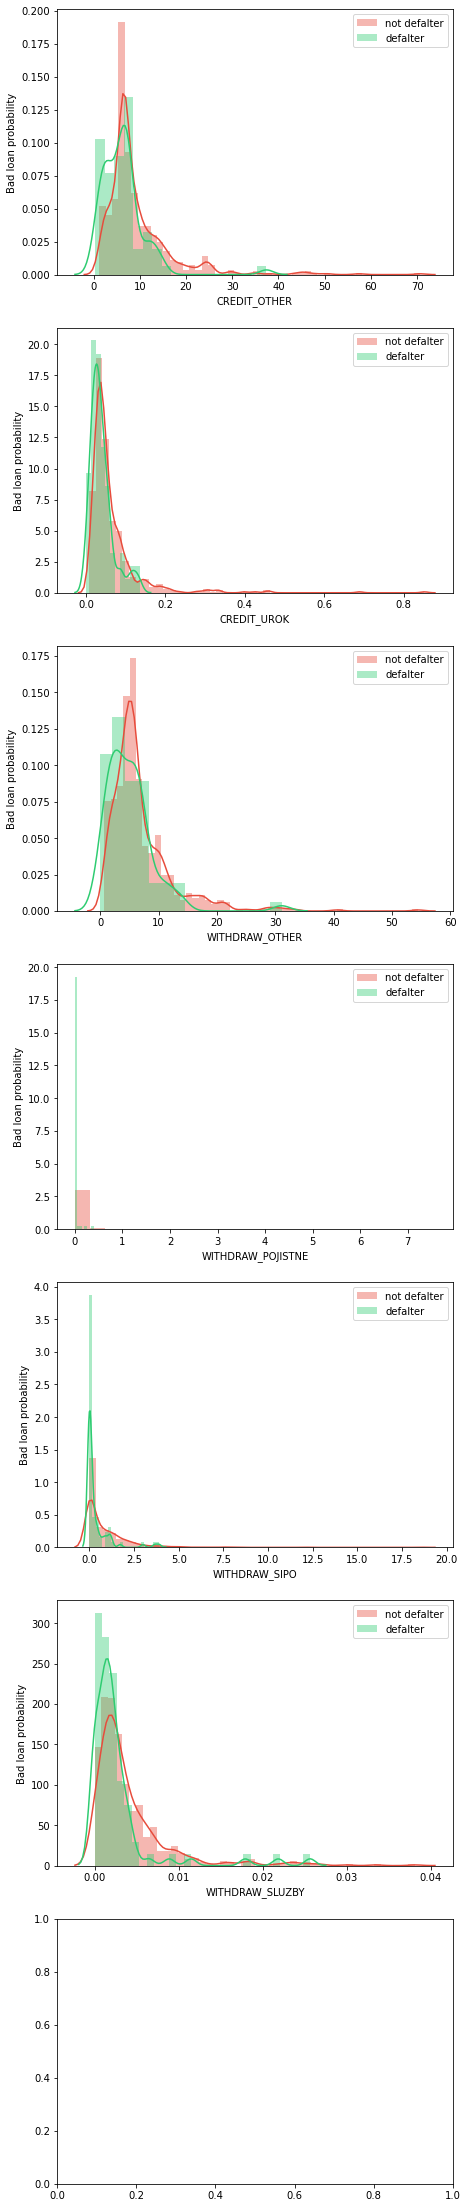

In [17]:
cont_features = ['CREDIT_OTHER', 'CREDIT_UROK', 'WITHDRAW_OTHER', 'WITHDRAW_POJISTNE', 'WITHDRAW_SIPO',
                 'WITHDRAW_SLUZBY']
defalter = updated_loan_clients['status'] == 1

fig, axs = plt.subplots(nrows=7, figsize=(4, 40))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(updated_loan_clients[~defalter][feature], label='not defalter', hist=True, color='#e74c3c', ax=axs[i])
    sns.distplot(updated_loan_clients[defalter][feature], label='defalter', hist=True, color='#2ecc71', ax=axs[i])
    
    axs[i].set_ylabel('Bad loan probability')
    axs[i].legend(loc='upper right', prop={'size': 10})

# axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
# axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

In [166]:
for feature in cont_features:
    updated_df['capped ' + feature] = updated_df[feature]
    q1, q3 = updated_df[feature].quantile([0.25, 0.75])
    iqr = q3 - q1
    top_boundary = q3 + (iqr * 1.5)
    updated_df.loc[updated_df['capped '+feature] >= top_boundary, 'capped '+feature] = top_boundary

In [33]:
updated_df.head()

,is_family,gender,age_loan,account_year_before_loan,account_date,loan_granted_date,loan_duration,monthly_payment,card_type,A2,...,BEFORE_VYDAJ_OTHER,BEFORE_VYDAJ_POJISTNE,BEFORE_VYDAJ_SIPO,BEFORE_VYDAJ_SLUZBY,BEFORE_VYDAJ_SANKC. UROK,account_balance,capped BEFORE_PRIJEM_OTHER,capped BEFORE_VYDAJ_OTHER,capped BEFORE_PRIJEM_UROK,capped BEFORE_VYDAJ_SLUZBY
2,1,Male,48,0,1993-02-26,1994-01-05,24,3373.0,None,Hl.m. Praha,...,4.67234,0.00000,1.03235,0.00255,0.0,8.256152,6.46164,4.672340,0.03667,0.00255
25,0,Female,57,1,1995-04-07,1996-04-29,12,2523.0,None,Tabor,...,3.02806,0.00000,3.90428,0.00369,0.0,6.283789,7.33496,3.028060,0.08688,0.00369
31,0,Male,35,1,1996-07-28,1997-12-08,12,2523.0,None,Frydek - Mistek,...,21.00178,0.05482,2.27876,0.00503,0.0,12.533492,17.33523,14.444334,0.09758,0.00503
45,0,Male,46,1,1997-08-18,1998-10-14,60,5308.0,None,Strakonice,...,5.38216,0.01558,0.37238,0.00220,0.0,3.083647,5.96064,5.382160,0.03084,0.00220
46,0,Female,58,0,1997-08-08,1998-04-19,48,2307.0,None,Prachatice,...,4.21608,0.04668,1.41322,0.00616,0.0,16.218899,7.54075,4.216080,0.05704,0.00616


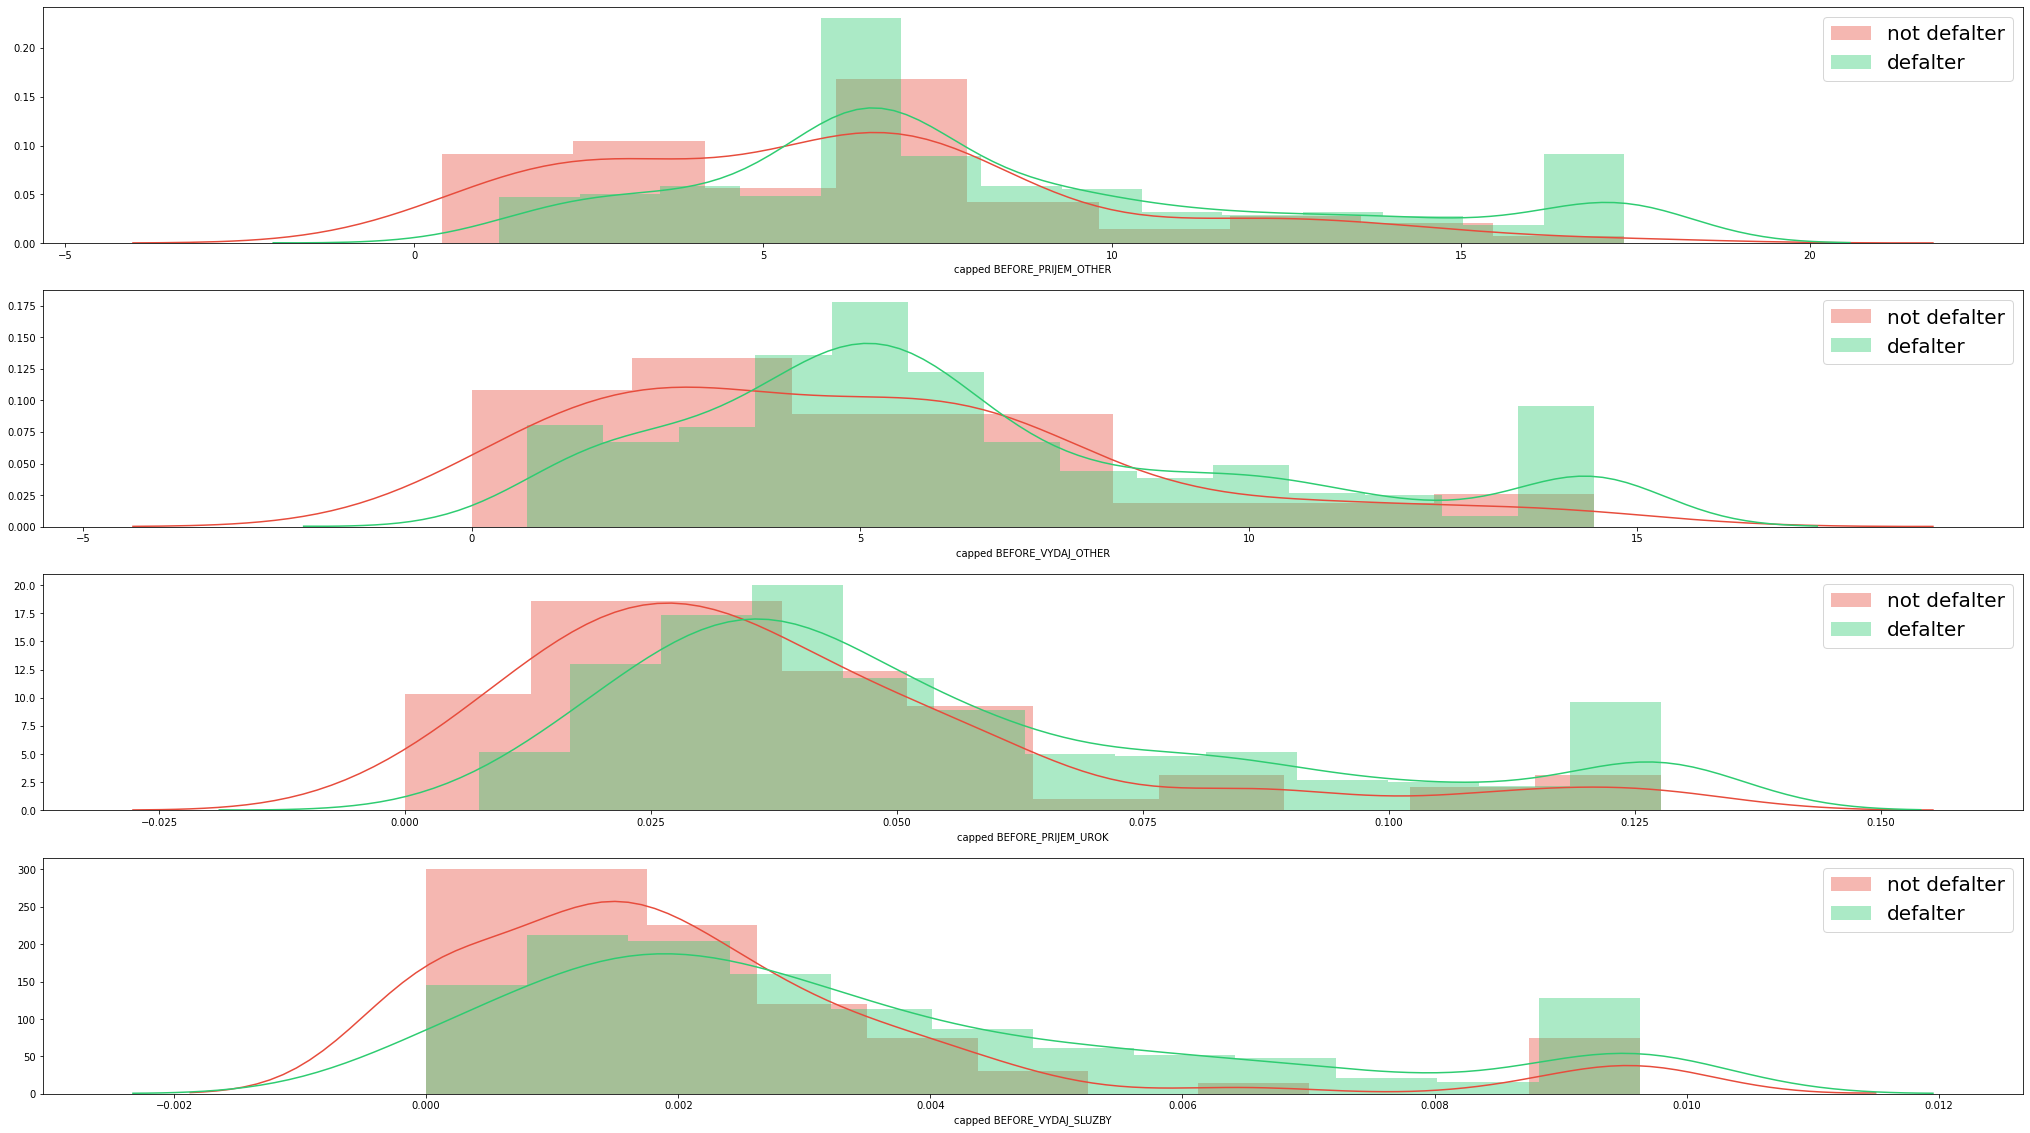

In [167]:
cont_features = ["BEFORE_PRIJEM_OTHER", "BEFORE_VYDAJ_OTHER", "BEFORE_PRIJEM_UROK", "BEFORE_VYDAJ_SLUZBY"]
defalter = updated_df['status'] == 0

fig, axs = plt.subplots(nrows=4, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(updated_df[~defalter]['capped '+feature], label='not defalter', hist=True, color='#e74c3c', ax=axs[i])
    sns.distplot(updated_df[defalter]['capped '+feature], label='defalter', hist=True, color='#2ecc71', ax=axs[i])
    
  
    axs[i].legend(loc='upper right', prop={'size': 20})
       
plt.show()

In [35]:
test=updated_df[["capped BEFORE_PRIJEM_OTHER","capped BEFORE_VYDAJ_OTHER", "capped BEFORE_VYDAJ_SLUZBY", 'status']]
test.corr().style.background_gradient(cmap='coolwarm', axis=None)

,capped BEFORE_PRIJEM_OTHER,capped BEFORE_VYDAJ_OTHER,capped BEFORE_VYDAJ_SLUZBY,status
capped BEFORE_PRIJEM_OTHER,1.000000,0.926507,0.518676,-0.172305
capped BEFORE_VYDAJ_OTHER,0.926507,1.000000,0.515563,-0.126859
capped BEFORE_VYDAJ_SLUZBY,0.518676,0.515563,1.000000,-0.147073
status,-0.172305,-0.126859,-0.147073,1.000000


#### 4.6 balance 
- lower balance is more likely to have bad loan payment

Text(0.5, 1.0, 'Balance distribution')

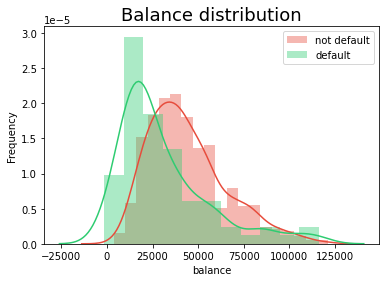

In [24]:
g = sns.distplot(updated_loan_clients["account_balance"][(updated_loan_clients["status"] == 0)], hist=True, color='#e74c3c',)
g = sns.distplot(updated_loan_clients["account_balance"][(updated_loan_clients["status"] == 1)], hist=True, color='#2ecc71', ax =g)
g.set_xlabel("balance")
g.set_ylabel("Frequency")
g = g.legend(["not default","default"])
plt.title('Balance distribution', fontsize=18)

#### 4.8 district
- coor is low of the paramters about disct
- region influences loans, maybe try region/A4-A15

In [122]:
dist=updated_loan_clients.loc[:,'A4':'A16']
dist['status']=updated_loan_clients['status']
# dist['aver_unemployment'] = (dist['A12']+dist['A13'])/2
dist.corr().style.background_gradient(cmap='coolwarm', axis=None)

,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,status
A4,1.000000,-0.535887,-0.547405,-0.457504,-0.183187,-0.614363,0.697678,0.910474,-0.464142,-0.507780,0.702264,0.995781,0.994392,-0.026483
A5,-0.535887,1.000000,0.442206,0.116068,-0.101561,0.386517,-0.627935,-0.589766,0.064779,0.035568,-0.306661,-0.513578,-0.504415,0.004688
A6,-0.547405,0.442206,1.000000,0.696636,0.123543,0.596714,-0.755772,-0.624052,0.156679,0.141305,-0.360466,-0.564802,-0.558126,-0.020196
A7,-0.457504,0.116068,0.696636,1.000000,0.159664,0.679394,-0.552185,-0.455545,0.163366,0.170577,-0.411019,-0.494042,-0.490131,-0.042940
A8,-0.183187,-0.101561,0.123543,0.159664,1.000000,0.313338,0.087511,-0.166631,0.564463,0.549128,-0.474285,-0.219547,-0.223223,-0.013263
A9,-0.614363,0.386517,0.596714,0.679394,0.313338,1.000000,-0.460808,-0.598698,0.214375,0.198670,-0.418806,-0.626057,-0.620097,-0.037178
A10,0.697678,-0.627935,-0.755772,-0.552185,0.087511,-0.460808,1.000000,0.780752,-0.113040,-0.157874,0.396754,0.678266,0.664736,0.000419
A11,0.910474,-0.589766,-0.624052,-0.455545,-0.166631,-0.598698,0.780752,1.000000,-0.368451,-0.427481,0.646734,0.905648,0.900038,-0.034555
A12,-0.464142,0.064779,0.156679,0.163366,0.564463,0.214375,-0.113040,-0.368451,1.000000,0.931699,-0.720852,-0.481169,-0.486869,0.006011
A13,-0.507780,0.035568,0.141305,0.170577,0.549128,0.198670,-0.157874,-0.427481,0.931699,1.000000,-0.725351,-0.521615,-0.524707,0.018071


In [123]:
dist.corr().sort_values(by=["status"]).status

A14      -0.046420
A7       -0.042940
A9       -0.037178
A11      -0.034555
A16      -0.027963
A15      -0.027208
A4       -0.026483
A6       -0.020196
A8       -0.013263
A10       0.000419
A5        0.004688
A12       0.006011
A13       0.018071
status    1.000000
Name: status, dtype: float64

# 5. Machine Learning

In [18]:
useless_features = ['A4', 'A5', 'A6', "A7", 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14',
                    'A15', 'A16', "A3", "status", 'loan_duration', 'account_date',
                    "account_year_before_loan", "monthly_payment", 'WITHDRAW_SANKC. UROK',
                    "A2", 'CREDIT_UROK']
ml = updated_loan_clients.drop(columns=useless_features)
ml['loan_granted_date'] = ml['loan_granted_date'].dt.to_period('Y').astype(int)

In [19]:
X = pd.get_dummies(ml, drop_first=True)
y = updated_loan_clients['status']

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 2 to 13971
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   is_family          682 non-null    int64  
 1   age_loan           682 non-null    int64  
 2   loan_granted_date  682 non-null    int64  
 3   CREDIT_OTHER       682 non-null    float64
 4   WITHDRAW_OTHER     682 non-null    float64
 5   WITHDRAW_POJISTNE  682 non-null    float64
 6   WITHDRAW_SIPO      682 non-null    float64
 7   WITHDRAW_SLUZBY    682 non-null    float64
 8   has_neg_balance    682 non-null    int64  
 9   account_balance    682 non-null    float64
 10  gender_Male        682 non-null    uint8  
 11  card_type_classic  682 non-null    uint8  
 12  card_type_gold     682 non-null    uint8  
 13  card_type_junior   682 non-null    uint8  
dtypes: float64(6), int64(4), uint8(4)
memory usage: 81.3 KB


In [21]:
X.shape

(682, 14)

In [22]:
y.shape

(682,)

### 5.1 Try different algorithm 

In [23]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [28]:
models = {'dt':DecisionTreeClassifier(), 'lr': LogisticRegression(random_state=1), 'knn': KNeighborsClassifier(), 
          'svc': SVC(), 'rf': RandomForestClassifier()}
score = {}

for name, model in models.items():
    pipe = Pipeline([
                    ('scaling', StandardScaler()),
                    ('ros', RandomOverSampler(random_state=42)),
                    (name, model)
                    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='recall')
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    score[name] = {'prec':precision_score(y_test, y_pred),
                   'rec':recall_score(y_test, y_pred),
                   'f1':f1_score(y_test, y_pred)
                  }
    
scores = pd.DataFrame(score).T.round(2).reset_index()

In [29]:
scores

,index,prec,rec,f1
0,dt,0.53,0.64,0.58
1,lr,0.35,0.88,0.50
2,knn,0.41,0.72,0.52
3,svc,0.44,0.80,0.57
4,rf,0.75,0.60,0.67


#### 5.1.1 Decision Tree

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

pipe1 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('Decision_tree', DecisionTreeClassifier())
])
scores = cross_val_score(pipe1, X_train, y_train, cv=3, scoring='f1')
pipe1.fit(X_train, y_train)
y_pred = pipe1.predict(X_test)
print(classification_report(y_test, y_pred), scores.mean())

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       201
           1       0.52      0.64      0.57        25

    accuracy                           0.89       226
   macro avg       0.73      0.78      0.76       226
weighted avg       0.91      0.89      0.90       226
 0.4222190104543045


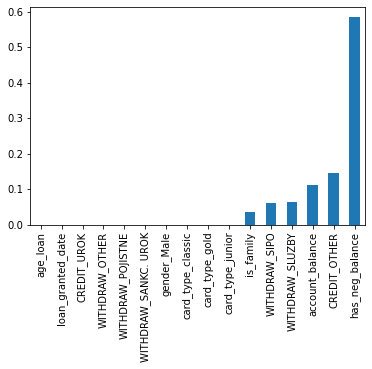

In [121]:
pd.Series(model.feature_importances_, X_train.columns).sort_values().plot(kind='bar');

#### 5.1.2 Logistic Regression

In [211]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(penalty='l1', solver='saga', random_state=1)
lr.fit(X_train_scaled, y_train_resampled)
y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       201
           1       0.36      0.88      0.51        25

    accuracy                           0.81       226
   macro avg       0.67      0.84      0.70       226
weighted avg       0.91      0.81      0.84       226



/home/lancelot/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


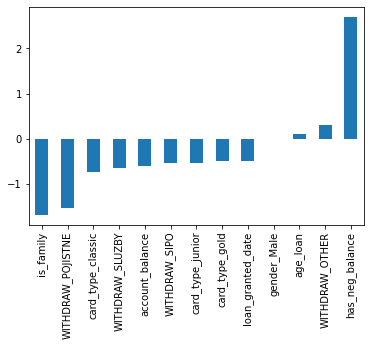

In [212]:
pd.Series(lr.coef_[0], X_train_resampled.columns).sort_values().plot(kind='bar');

In [89]:
pipe2 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('logistic_regression', LogisticRegression(random_state=1))
])
scores2 = cross_val_score(pipe2, X_train, y_train, cv=3, scoring='f1')
pipe2.fit(X_train, y_train)
y_pred = pipe2.predict(X_test)
print(classification_report(y_test, y_pred), scores2.mean())

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       201
           1       0.35      0.88      0.50        25

    accuracy                           0.81       226
   macro avg       0.67      0.84      0.69       226
weighted avg       0.91      0.81      0.84       226
 0.4171980676328502


#### 5.1.3 KNN

In [88]:
pipe3 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('knn', KNeighborsClassifier())
])
scores3 = cross_val_score(pipe3, X_train, y_train, cv=3, scoring='f1')
pipe3.fit(X_train, y_train)
y_pred = pipe3.predict(X_test)
print(classification_report(y_test, y_pred), scores3.mean())

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       201
           1       0.41      0.72      0.52        25

    accuracy                           0.85       226
   macro avg       0.69      0.80      0.72       226
weighted avg       0.90      0.85      0.87       226
 0.44234305227213033


#### 5.1.4 SVC

In [87]:
pipe4 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('svc', SVC())
])
scores4 = cross_val_score(pipe4, X_train, y_train, cv=3, scoring='f1')
pipe4.fit(X_train, y_train)
y_pred = pipe4.predict(X_test)
print(classification_report(y_test, y_pred), scores4.mean())

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       201
           1       0.44      0.80      0.57        25

    accuracy                           0.87       226
   macro avg       0.71      0.84      0.75       226
weighted avg       0.91      0.87      0.88       226
 0.4824384192805245


#### 5.1.5 RandomForest

In [86]:
pipe5 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('random_forest', RandomForestClassifier())
])
scores5 = cross_val_score(pipe5, X_train, y_train, cv=3, scoring='f1')
pipe5.fit(X_train, y_train)
y_pred = pipe5.predict(X_test)
print(classification_report(y_test, y_pred), scores5.mean())


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       201
           1       0.76      0.64      0.70        25

    accuracy                           0.94       226
   macro avg       0.86      0.81      0.83       226
weighted avg       0.93      0.94      0.94       226
 0.6211992945326278


### 5.2 Gridsearch
- Compare the three algorithms, decision tree is the best

#### 5.2.1 Decision Tree

In [127]:
parameters = {
    'Decisiontree__max_depth': list(range(1,10)),
    'Decisiontree__criterion': ['gini', 'entropy'],
#     'Decisiontree__splitter': ['best', 'random'],
    'Decisiontree__min_samples_split': [2, 5, 8, 10]
}

pipe1 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('Decisiontree', DecisionTreeClassifier())
])
gs = GridSearchCV(pipe1, parameters, cv=5, scoring='f1', n_jobs=4)
gs.fit(X_train, y_train)
gs.best_params_

{'Decisiontree__criterion': 'gini',
 'Decisiontree__max_depth': 9,
 'Decisiontree__min_samples_split': 10}

In [128]:
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       201
           1       0.44      0.68      0.53        25

    accuracy                           0.87       226
   macro avg       0.70      0.79      0.73       226
weighted avg       0.90      0.87      0.88       226



In [130]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}
f1 (test): {f1_test:.3f}''')

Accuracy (test): 0.867
Precision (test): 0.436
Recall (test): 0.680
f1 (test): 0.531


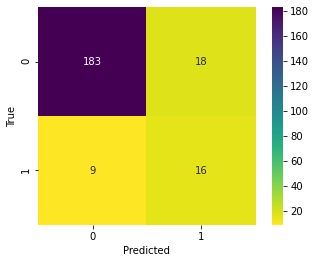

In [174]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

#### 5.2.2 Logistic Regression

In [190]:
parameters = {
    'logistic_regression__C': [1e-3, 3e-3, .01, .03, 0.1, .3, 1, 3, 10]
}

pipe2 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('logistic_regression', LogisticRegression(random_state=1, n_jobs=4))
])
gs1 = GridSearchCV(pipe2, parameters, cv=5, scoring='recall', n_jobs=4)
gs1.fit(X_train, y_train)
gs1.best_params_

{'logistic_regression__C': 0.1}

In [191]:
best_model = gs1.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       201
           1       0.37      0.88      0.52        25

    accuracy                           0.82       226
   macro avg       0.68      0.85      0.71       226
weighted avg       0.91      0.82      0.85       226



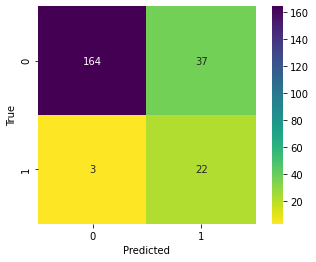

In [192]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [189]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

Accuracy (test): 0.934
Precision (test): 1.000
Recall (test): 0.400


##### 5.2.3 Random Forest

In [93]:
parameters = {
    'rf__n_estimators': [10,30,50,75,100,150],
    'rf__max_depth': [4, 6, 10, 12, 15],
}

pipe2 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced'))
])
gs3 = GridSearchCV(pipe2, parameters, cv=5, scoring='f1', n_jobs=4)
gs3.fit(X_train, y_train)
gs3.best_params_

{'rf__max_depth': 12, 'rf__n_estimators': 30}

In [204]:
best_model = gs3.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       201
           1       0.77      0.68      0.72        25

    accuracy                           0.94       226
   macro avg       0.87      0.83      0.85       226
weighted avg       0.94      0.94      0.94       226



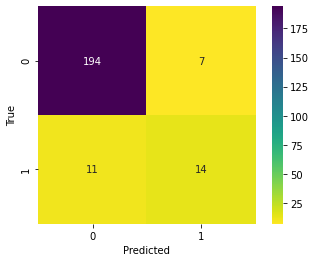

In [80]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

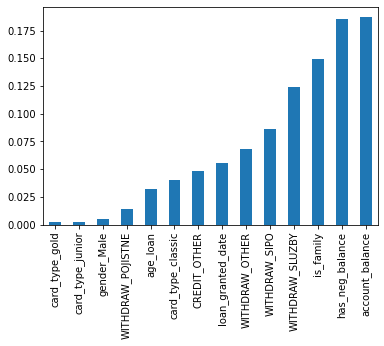

In [72]:
pd.Series(gs3.best_estimator_.named_steps['rf'].feature_importances_, X_train.columns).sort_values().plot(kind='bar');

#### 5.2.3 Gradient Descent

In [195]:
parameters = {
    'gd__loss': ['log','squared_loss','huber', 'epsilon_insensitive'],
    'gd__penalty': ['l2', 'l1', 'elasticnet']
}
pipe5 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('gd', SGDClassifier())
])
gs = GridSearchCV(pipe5, parameters, cv=5, scoring='f1', n_jobs=4)
gs.fit(X_train, y_train)
gs.best_params_

{'gd__loss': 'log', 'gd__penalty': 'l1'}

In [196]:
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       201
           1       0.31      0.88      0.45        25

    accuracy                           0.77       226
   macro avg       0.64      0.82      0.65       226
weighted avg       0.91      0.77      0.81       226



In [197]:
y_pred_train = best_model.predict(X_train)
print('Test Score:', accuracy_score(y_test, y_pred))
print('Train Score:', accuracy_score(y_train, y_pred_train))

Test Score: 0.7654867256637168
Train Score: 0.7149122807017544


## 6. Ensembling

#### 6.1 Voting

In [80]:
from sklearn.ensemble import VotingClassifier

In [81]:
# clf1 = Pipeline([
#     ('scaling', StandardScaler()),
#     ('ros', RandomOverSampler(random_state=42)),
#     ('logistic_regression', LogisticRegression(random_state=1, n_jobs=4))
# ])

clf2 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('Decisiontree', DecisionTreeClassifier())
])

clf3 = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# clf1 = LogisticRegression(random_state=1)
# clf2 = DecisionTreeClassifier()
# clf3 = KNeighborsClassifier()

estimators=[('DT', clf2), ('KNN', clf3)]
eclf = VotingClassifier(estimators, voting='soft')

params = {
    'KNN__knn__n_neighbors': [5, 10, 20],
    'DT__Decisiontree__max_depth': list(range(1,10)),
    'DT__Decisiontree__criterion': ['gini', 'entropy'],
    'DT__Decisiontree__min_samples_split': [2, 5, 8, 10],
}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5, scoring='f1', n_jobs=4)
grid.fit(X_train, y_train)
grid.best_params_

{'DT__Decisiontree__criterion': 'gini',
 'DT__Decisiontree__max_depth': 9,
 'DT__Decisiontree__min_samples_split': 8,
 'KNN__knn__n_neighbors': 10}

In [82]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       201
           1       0.29      0.36      0.32        25

    accuracy                           0.83       226
   macro avg       0.60      0.63      0.61       226
weighted avg       0.85      0.83      0.84       226



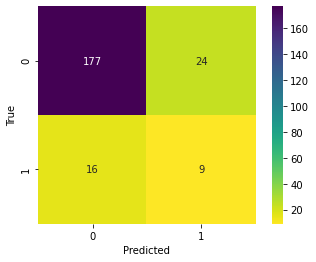

In [85]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

#### 6.2 Bagging

In [88]:
from sklearn.ensemble import BaggingClassifier

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('Decisiontree', DecisionTreeClassifier())
])

param_grid = {
    'base_estimator__Decisiontree__max_depth': list(range(1,10)),
    'base_estimator__Decisiontree__criterion': ['gini', 'entropy'],
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'max_features' : [2, 4, 6]
}

clf = GridSearchCV(BaggingClassifier(pipe,n_estimators=50, random_state=42),
                   param_grid, scoring = 'f1', n_jobs=4)
clf.fit(X_train, y_train)
clf.best_params_

{'base_estimator__Decisiontree__criterion': 'gini',
 'base_estimator__Decisiontree__max_depth': 3,
 'max_features': 6,
 'max_samples': 0.5}

In [89]:
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       201
           1       0.56      0.40      0.47        25

    accuracy                           0.90       226
   macro avg       0.74      0.68      0.70       226
weighted avg       0.89      0.90      0.89       226



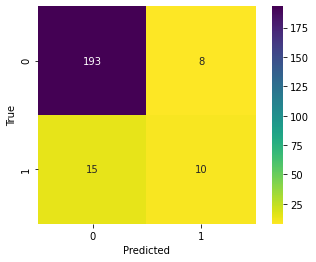

In [90]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

#### 6.3 xgb boost

In [197]:
import xgboost as xgb
from xgboost import XGBClassifier

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('ros', RandomOverSampler(random_state=42)),
    ('xgb', XGBClassifier())
])

param_grid = {
    'xgb__booster': ['gbtree', 'dart'],
    'xgb__eta': [1e-3, 3e-3, .01, .03, 0.1, 0.3, 0.4],
    'xgb__gamma': list(range(5)),
    'xgb__max_depth': [6, 8, 10],
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', n_jobs=4)
grid.fit(X_train, y_train)
grid.best_params_

{'xgb__booster': 'gbtree',
 'xgb__eta': 0.3,
 'xgb__gamma': 1,
 'xgb__max_depth': 6}

In [202]:
best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred = np.where(y_proba > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       201
           1       0.75      0.72      0.73        25

    accuracy                           0.94       226
   macro avg       0.86      0.85      0.85       226
weighted avg       0.94      0.94      0.94       226

Accuracy (test): 0.942
Precision (test): 0.750
Recall (test): 0.720


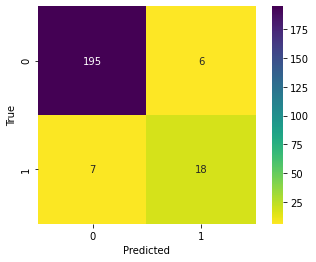

In [203]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [114]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9102487562189054

Text(0.5, 0, 'False Positive Rate')

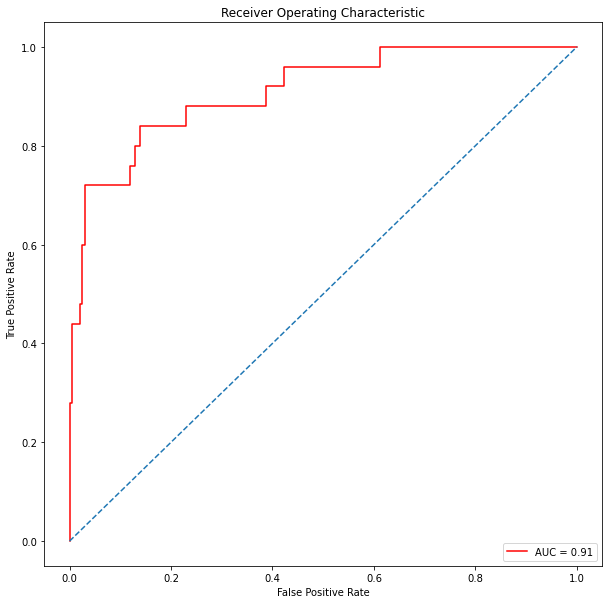

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [117]:
best_model.predict_proba(X_test)

array([[0.99712044, 0.00287956],
       [0.99331224, 0.00668777],
       [0.9957618 , 0.00423817],
       [0.88986474, 0.11013523],
       [0.961043  , 0.03895699],
       [0.98777664, 0.01222336],
       [0.9814218 , 0.01857814],
       [0.9742855 , 0.02571449],
       [0.8443889 , 0.1556111 ],
       [0.96688884, 0.03311118],
       [0.978688  , 0.02131199],
       [0.9284671 , 0.07153292],
       [0.996915  , 0.00308501],
       [0.9955021 , 0.00449788],
       [0.98663753, 0.01336245],
       [0.9797497 , 0.02025029],
       [0.9721606 , 0.02783944],
       [0.7974946 , 0.2025054 ],
       [0.99797636, 0.00202365],
       [0.05562228, 0.9443777 ],
       [0.9749265 , 0.02507355],
       [0.99329257, 0.00670741],
       [0.47006345, 0.52993655],
       [0.6323823 , 0.36761776],
       [0.9744457 , 0.0255543 ],
       [0.9402982 , 0.05970179],
       [0.9917036 , 0.00829635],
       [0.9858725 , 0.01412748],
       [0.45908964, 0.54091036],
       [0.9964951 , 0.0035049 ],
       [0.

In [202]:
result = X_test.copy()
result['real_status'] = y_test
result['predicted_status'] = best_model.predict_proba(X_test)[:,0]

In [203]:
result['predict'] = y_pred

In [204]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values,
                                feature_names=X_train.columns.values,
                                class_names=['no_defaulter','defaulter']) 

In [205]:
# Pick a passenger we want to analyze
client_id = 946

# Get the explaination of black box model
exp = explainer.explain_instance(X_test.loc[946], best_model.predict_proba)

# Display explanation
exp.show_in_notebook()

In [104]:
import xgboost
import shap
shap.initjs()

In [113]:
explainer = shap.KernelExplainer(best_model.predict_proba, X_train, link='logit')
shap_values = explainer.shap_values(X_test, nsamples=100)

Using 456 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [119]:
shap.force_plot(explainer.expected_value[0], shap_values[0][10,:], X_test.iloc[10,:], link="logit")

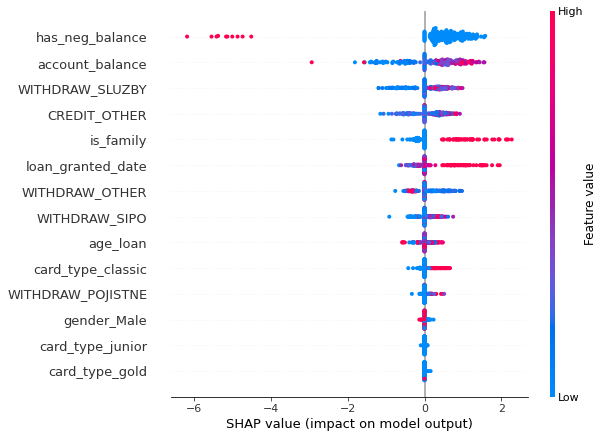

In [205]:
shap.summary_plot(shap_values[0], X_test)

In [253]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

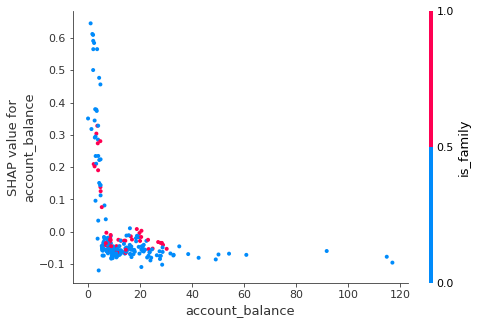

In [240]:
shap.dependence_plot("account_balance", shap_values, X_test)

In [110]:
result['predicted_status'] = best_model.predict_proba(X_test)

In [111]:
result

{'client_id': 2,
 'account_id': 2,
 'loan_id': 4959,
 'is_family': 1,
 'gender': 'Male',
 'age_loan': 48,
 'account_year_before_loan': 0,
 'account_date': '1993-02-26',
 'loan_granted_date': '1994-01-05',
 'loan_end_date': '1996-01-05',
 'loan_duration': 24,
 'monthly_payment': Decimal('3373.00'),
 'transcation_date': '1998-08-29',
 'trascation_type': 'VYDAJ',
 'k_symbol': '',
 'operation': 'VYBER',
 'transaction_amount': 3100,
 'account_balance': 42686,
 'transaction_before_loan': 'AFTER',
 'card_type': None,
 'district_id': 1,
 'A2': 'Hl.m. Praha',
 'A3': 'Prague',
 'A4': 1204953,
 'A5': 0,
 'A6': 0,
 'A7': 0,
 'A8': 1,
 'A9': 1,
 'A10': Decimal('100.00'),
 'A11': 12541,
 'A12': Decimal('0.29'),
 'A13': Decimal('0.43'),
 'A14': 167,
 'A15': 85677,
 'A16': 99107,
 'status': 'A',
 'predicted_status': array([0.99712044, 0.99331224, 0.9957618 , 0.88986474, 0.961043  ,
        0.98777664, 0.9814218 , 0.9742855 , 0.8443889 , 0.96688884,
        0.978688  , 0.9284671 , 0.996915  , 0.9955021

#### 6.4 Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier